### Utilities

In [1]:
import json

def filter_entries_from_json(path, kw="validation"):
    """
    Load json file of `stats`.
    """
    print(f"Reading json file {path}")
    validation = []
    with open(path, "r") as f:
        for i, line in enumerate(f):
            line = line.strip().replace("'", '"')
            line = line.replace("nan", '"nan"')
            line = line.replace("inf", '"inf"')
            line = line.replace("'", '"')
            if "mozi" in line:
                continue
            try:
                data = json.loads(line)
            except:
                print(path)
                print(i)
                print(line)
                raise
            if data["_meta"]["type"] == kw:
                validation.append(data)
    return validation


### Verify Assumption

In [3]:

STATS_PATH = "./synthetic/outputs/synthetic/verify_assumption/eta0.0001_beta0.9_local1_center_oracle_GT_DX4,75,9,10/stats"
data = filter_entries_from_json(STATS_PATH, "Verify Assumption")

Reading json file ./synthetic/outputs/synthetic/verify_assumption/eta0.0001_beta0.9_local1_center_oracle_GT_DX4,75,9,10/stats


In [4]:
K = 4
n = 300
cluster_size = n // K
A2_list = []
Delta2_list = []
for entry in data:
    A2 = []
    for k in range(K):
        ccgn2 = entry['ClusterCenterGradNorms'][k] ** 2
        for i in range(k*cluster_size, (k+1)*cluster_size):
            icd2 = entry['IntraClusterDistances'][i] ** 2
            A2.append(icd2 / ccgn2)
    A2_list.append(A2)

    n = len(entry['ClusterCenterDistances'])
    distances = []
    for i in range(n):
        a = []
        for j in range(n):
            if (i // cluster_size) != (j // cluster_size):
                a.append(entry['ClusterCenterDistances'][i][j])
        distances.append(min(a) ** 2)
    Delta2_list.append(distances)


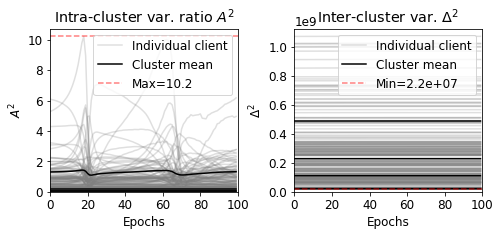

In [22]:
import matplotlib.pyplot as plt

K = 4
n = 300
EPOCHS = 100
cluster_size = n // K

# ICML has a text width of 6.75
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.75, 3), sharex=True)

def plot_A2(ax, A2_list):
    # ax.set_title(r"$\frac{|| \nabla f_i(x) - \nabla \bar{f}_i(x) ||_2^2}{|| \nabla \bar{f}_i(x) ||_2^2}$ ")
    ax.set_title(r"Intra-cluster var. ratio $A^2$")
    for i in range(n):
        kwargs = {} if i != 0 else {"label": "Individual client"}
        ax.plot(list(map(lambda x: x[i], A2_list)), c='grey', alpha=0.25, **kwargs)

    for k in range(K):
        def fn(x):
            return sum(x[k*cluster_size:(k+1)*cluster_size]) / cluster_size
        kwargs = {} if k != 0 else {"label": "Cluster mean"}
        ax.plot(list(map(fn, A2_list)), c='k', **kwargs)

    max_value = max(map(lambda x: max(x), A2_list))
    ax.axhline(max_value, c='r', alpha=0.5, ls='--', label=f'Max={max_value:.1f}')
    ax.legend(loc='upper right')
    ax.set_xlim(0, EPOCHS)
    ax.set_ylim(0, )
    ax.set_xlabel("Epochs")
    ax.set_ylabel(r"$A^2$")

plot_A2(axes[0], A2_list)

def plot_Delta2(ax, Delta2_list):
    ax.set_title(r"Inter-cluster var. $\Delta^2$")
    for i in range(n):
        kwargs = {} if i != 0 else {"label": "Individual client"}
        ax.plot(list(map(lambda x: x[i], Delta2_list)), c='grey', alpha=0.25, **kwargs)

    for k in range(K):
        def fn(x):
            return sum(x[k*cluster_size:(k+1)*cluster_size]) / cluster_size
        kwargs = {} if k != 0 else {"label": "Cluster mean"}
        ax.plot(list(map(fn, Delta2_list)), c='k', **kwargs)

    min_value = min(map(lambda x: min(x), Delta2_list))

    ax.axhline(min_value, c='r', alpha=0.5, ls='--', label=f'Min={min_value:.1e}')
    ax.set_ylim(0,)
    ax.legend(loc='upper right')
    ax.set_xlabel("Epochs")
    ax.set_ylabel(r"$\Delta^2$")

plot_Delta2(axes[1], Delta2_list)

plt.subplots_adjust(wspace=0.3)
fig.savefig("./figures/A_Delta2.pdf", bbox_inches='tight')

### Synthetic performances

In [2]:
PATTERN = "./synthetic/outputs/synthetic/D3/eta{eta}_beta0.9_local1_center_oracle_{method}_D3/stats"
methods = [
    ('GT', 0.1, 'Groundtruth'), 
    ('Thresholding', 0.1, 'FC'),
    ('DummyPersonalized', 0.1, 'Local'),
    ('IFCA_Model', 0.01, 'IFCA-M'),
    # ('IFCA', 0.01, 'IFCA-G'),
    ('Centralized', 0.1, 'Global'),
]

losses = {}
for method, eta, name in methods:
    losses[name] = []
    path = PATTERN.format(eta=eta, method=method)
    data = filter_entries_from_json(path, "hist")
    for entry in data:
        losses[name].append(entry['Loss'])

Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_GT_D3/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_Thresholding_D3/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_DummyPersonalized_D3/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.01_beta0.9_local1_center_oracle_IFCA_Model_D3/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_Centralized_D3/stats


In [3]:
PATTERN = "./synthetic/outputs/synthetic/D3/eta{eta}_beta0.9_local1_center_oracle_{method}_DX4,16,9,10/stats"
methods = [
    ('GT', 0.1, 'Groundtruth'), 
    ('Thresholding=Q0.25', 0.1, 'FC'),
    ('DummyPersonalized', 0.1, 'Local'),
    ('IFCA_Model', 0.1, 'IFCA-M'),
    # ('IFCA', 0.01, 'IFCA (Grad)'),
    ('Centralized', 0.1, 'Global'),
]

losses4Xper = {}
for method, eta, name in methods:
    losses4Xper[name] = []
    path = PATTERN.format(eta=eta, method=method)
    data = filter_entries_from_json(path, "hist")
    for entry in data:
        losses4Xper[name].append(entry['Loss'])

Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_GT_DX4,16,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_Thresholding=Q0.25_DX4,16,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_DummyPersonalized_DX4,16,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_IFCA_Model_DX4,16,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.1_beta0.9_local1_center_oracle_Centralized_DX4,16,9,10/stats


In [4]:
PATTERN = "./synthetic/outputs/synthetic/D3/eta{eta}_beta0.9_local1_center_oracle_{method}_DX16,4,9,10/stats"
methods = [
    ('GT', 0.01, 'GT'), 
    ('Thresholding=Q0.0625', 0.01, 'FC'),
    ('DummyPersonalized', 0.01, 'Local'),
    ('IFCA_Model', 0.001, 'IFCA-M'),
    # ('IFCA', 0.005, 'IFCA (Grad)'),
    ('Centralized', 0.001, 'FedAvg'),
]

losses4XCluster = {}
for method, eta, name in methods:
    losses4XCluster[name] = []
    path = PATTERN.format(eta=eta, method=method)
    data = filter_entries_from_json(path, "hist")
    for entry in data:
        losses4XCluster[name].append(entry['Loss'])

Reading json file ./synthetic/outputs/synthetic/D3/eta0.01_beta0.9_local1_center_oracle_GT_DX16,4,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.01_beta0.9_local1_center_oracle_Thresholding=Q0.0625_DX16,4,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.01_beta0.9_local1_center_oracle_DummyPersonalized_DX16,4,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.001_beta0.9_local1_center_oracle_IFCA_Model_DX16,4,9,10/stats
Reading json file ./synthetic/outputs/synthetic/D3/eta0.001_beta0.9_local1_center_oracle_Centralized_DX16,4,9,10/stats


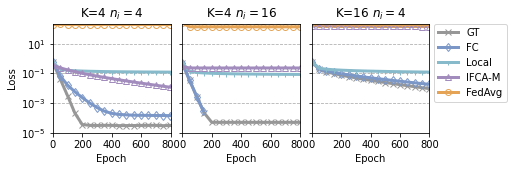

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt

EPOCHS = 800
colors = [(152, 152, 152), (123,152,201), (136,187,203), (162, 141, 190), (230,165,85)]
colors = [tuple(j/256 for j in i) for i in colors]
markers = 'xd1^os'
# ICML has a text width of 6.75
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6.75, 2), sharex=True, sharey=True)
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8.5, 2.5), sharex=True, sharey=True)

def plot_losses(ax, losses, title=''):

    for i, method in enumerate(losses):
        x = list(range(len(losses[method])))
        ysmoothed = gaussian_filter1d(losses[method], sigma=2)

        plot_x = x[::50] + [x[-1]]
        plot_y = list(ysmoothed)[::50] + [ysmoothed[-1]]

        ax.plot(plot_x, plot_y, c=colors[i], lw=3, marker=markers[i],
        markerfacecolor='none',
         label=method)

    ax.set_title(title)
    ax.set_xticks(list(range(EPOCHS+1))[::200])
    ax.set_xlim(0, EPOCHS)
    ax.set_ylim(10e-6, )
    ax.set_yscale('log')
    ax.set_xlabel("Epoch")
    ax.grid(axis='y', which='both', ls='--')

plot_losses(axes[0], losses, title=r"K=4 $n_i=4$")
plot_losses(axes[1], losses4Xper, title=r"K=4 $n_i=16$")
plot_losses(axes[2], losses4XCluster, title=r"K=16 $n_i=4$")

axes[0].set_ylabel("Loss")
axes[2].legend(bbox_to_anchor=(1., 1.05))

fig.subplots_adjust(
    # left=0.01,
    # bottom=0.1,
    # right=0.99,
    # top=0.9,
    wspace=0.1,
    hspace=0.6)

# fig.savefig("./figures/synthetic.pdf", bbox_inches='tight')